In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
num_epochs = 500
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [3]:
initialize=True

In [4]:
df = pd.read_csv('../data/united_data.csv', index_col=0).fillna(0)
y = df['Corn_Yield']
X = df.drop(columns=['Corn_Yield'], axis=1)

In [5]:
y = pd.DataFrame(y)
def convert_corn_yield(row):
    idx = row.name
    year = int(idx[:4])
    row['Corn_Yield'] = row['Corn_Yield'] + (1950-year)*1.96966271
    return row
    

In [6]:
y = y.apply(convert_corn_yield, axis=1)
y = y['Corn_Yield']

In [7]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [9]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [10]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)


In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [12]:
model = LSTM(input_size, hidden_size, num_layers)
weather_test = X_test.reshape(-1, sequence_length, input_size)
weather_train = X_train.reshape(-1, sequence_length, input_size)
print(weather_test.shape)
print(weather_train.shape)

torch.Size([363, 4, 222])
torch.Size([1086, 4, 222])


## Train the model

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
train_losses = []
test_losses = []
min_test_loss = 9999999
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs.reshape(-1), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            outputs = model(weather_train)
            loss_train = criterion(outputs.reshape(-1), y_train)
            outputs = model(weather_test)
            loss_test = criterion(outputs.reshape(-1), y_test)
            train_losses.append(loss_train)
            test_losses.append(loss_test)
            if loss_test < min_test_loss:
                torch.save(model.state_dict(), "lstm-adjusted-500")
            print("Epoch: ", epoch + 1, " Train loss: ", loss_train.item(), "Test loss:", loss_test.item())

Epoch:  1  Train loss:  765.5917358398438 Test loss: 722.1902465820312
Epoch:  2  Train loss:  731.3231811523438 Test loss: 696.956787109375
Epoch:  3  Train loss:  669.17578125 Test loss: 638.3350830078125
Epoch:  4  Train loss:  561.1145629882812 Test loss: 529.85595703125
Epoch:  5  Train loss:  566.0662841796875 Test loss: 516.4517822265625
Epoch:  6  Train loss:  527.6874389648438 Test loss: 469.0144958496094
Epoch:  7  Train loss:  498.442626953125 Test loss: 451.5618591308594
Epoch:  8  Train loss:  485.6777648925781 Test loss: 418.3889465332031
Epoch:  9  Train loss:  490.3936462402344 Test loss: 420.6943359375
Epoch:  10  Train loss:  504.1999816894531 Test loss: 400.73046875
Epoch:  11  Train loss:  472.9745178222656 Test loss: 371.9531555175781
Epoch:  12  Train loss:  462.6526794433594 Test loss: 371.7868957519531
Epoch:  13  Train loss:  486.5079345703125 Test loss: 359.2327575683594
Epoch:  14  Train loss:  468.1556091308594 Test loss: 350.8061828613281
Epoch:  15  Train 

Epoch:  115  Train loss:  455.79034423828125 Test loss: 146.56532287597656
Epoch:  116  Train loss:  440.8733215332031 Test loss: 158.02703857421875
Epoch:  117  Train loss:  453.1376037597656 Test loss: 135.73184204101562
Epoch:  118  Train loss:  461.6145935058594 Test loss: 124.97144317626953
Epoch:  119  Train loss:  423.0119934082031 Test loss: 161.49412536621094
Epoch:  120  Train loss:  476.61480712890625 Test loss: 141.11782836914062
Epoch:  121  Train loss:  456.6510314941406 Test loss: 122.2005386352539
Epoch:  122  Train loss:  420.7524108886719 Test loss: 127.19369506835938
Epoch:  123  Train loss:  475.9644470214844 Test loss: 138.23486328125
Epoch:  124  Train loss:  444.6163024902344 Test loss: 150.89230346679688
Epoch:  125  Train loss:  426.5755615234375 Test loss: 106.15074920654297
Epoch:  126  Train loss:  462.8517150878906 Test loss: 92.22837829589844
Epoch:  127  Train loss:  442.9160461425781 Test loss: 100.71070861816406
Epoch:  128  Train loss:  433.35864257812

Epoch:  227  Train loss:  404.921630859375 Test loss: 74.71465301513672
Epoch:  228  Train loss:  410.8762512207031 Test loss: 78.34477233886719
Epoch:  229  Train loss:  418.5833740234375 Test loss: 80.24422454833984
Epoch:  230  Train loss:  444.9691162109375 Test loss: 81.42240142822266
Epoch:  231  Train loss:  413.7729797363281 Test loss: 84.54212188720703
Epoch:  232  Train loss:  421.0425720214844 Test loss: 81.58616638183594
Epoch:  233  Train loss:  421.1622314453125 Test loss: 71.63917541503906
Epoch:  234  Train loss:  459.9340515136719 Test loss: 91.06017303466797
Epoch:  235  Train loss:  410.8392639160156 Test loss: 83.0856704711914
Epoch:  236  Train loss:  417.5211486816406 Test loss: 90.69340515136719
Epoch:  237  Train loss:  441.36590576171875 Test loss: 71.50626373291016
Epoch:  238  Train loss:  422.43121337890625 Test loss: 74.3700180053711
Epoch:  239  Train loss:  427.14007568359375 Test loss: 67.05574035644531
Epoch:  240  Train loss:  429.8939208984375 Test lo

Epoch:  340  Train loss:  451.52099609375 Test loss: 61.19393539428711
Epoch:  341  Train loss:  435.3545837402344 Test loss: 64.192138671875
Epoch:  342  Train loss:  472.5862121582031 Test loss: 90.99999237060547
Epoch:  343  Train loss:  439.9771728515625 Test loss: 71.69847869873047
Epoch:  344  Train loss:  422.32965087890625 Test loss: 51.45835876464844
Epoch:  345  Train loss:  531.486572265625 Test loss: 125.27883911132812
Epoch:  346  Train loss:  452.50823974609375 Test loss: 59.423458099365234
Epoch:  347  Train loss:  519.3999633789062 Test loss: 95.04842376708984
Epoch:  348  Train loss:  497.1424865722656 Test loss: 75.11840057373047
Epoch:  349  Train loss:  471.801513671875 Test loss: 70.71804809570312
Epoch:  350  Train loss:  434.802490234375 Test loss: 61.38438415527344
Epoch:  351  Train loss:  487.1695556640625 Test loss: 98.02974700927734
Epoch:  352  Train loss:  437.5647277832031 Test loss: 57.085227966308594
Epoch:  353  Train loss:  462.22235107421875 Test los

Epoch:  452  Train loss:  404.39013671875 Test loss: 44.02470016479492
Epoch:  453  Train loss:  417.7301025390625 Test loss: 51.476890563964844
Epoch:  454  Train loss:  415.0359191894531 Test loss: 65.22034454345703
Epoch:  455  Train loss:  420.3410339355469 Test loss: 49.45341110229492
Epoch:  456  Train loss:  420.29052734375 Test loss: 54.00971603393555
Epoch:  457  Train loss:  413.0281982421875 Test loss: 46.63177490234375
Epoch:  458  Train loss:  421.57867431640625 Test loss: 53.467857360839844
Epoch:  459  Train loss:  430.9135437011719 Test loss: 49.102596282958984
Epoch:  460  Train loss:  406.0887756347656 Test loss: 47.83879089355469
Epoch:  461  Train loss:  427.7042541503906 Test loss: 61.19816970825195
Epoch:  462  Train loss:  425.9527893066406 Test loss: 62.84541320800781
Epoch:  463  Train loss:  503.34368896484375 Test loss: 127.97537994384766
Epoch:  464  Train loss:  436.1206359863281 Test loss: 85.60252380371094
Epoch:  465  Train loss:  425.2961120605469 Test 

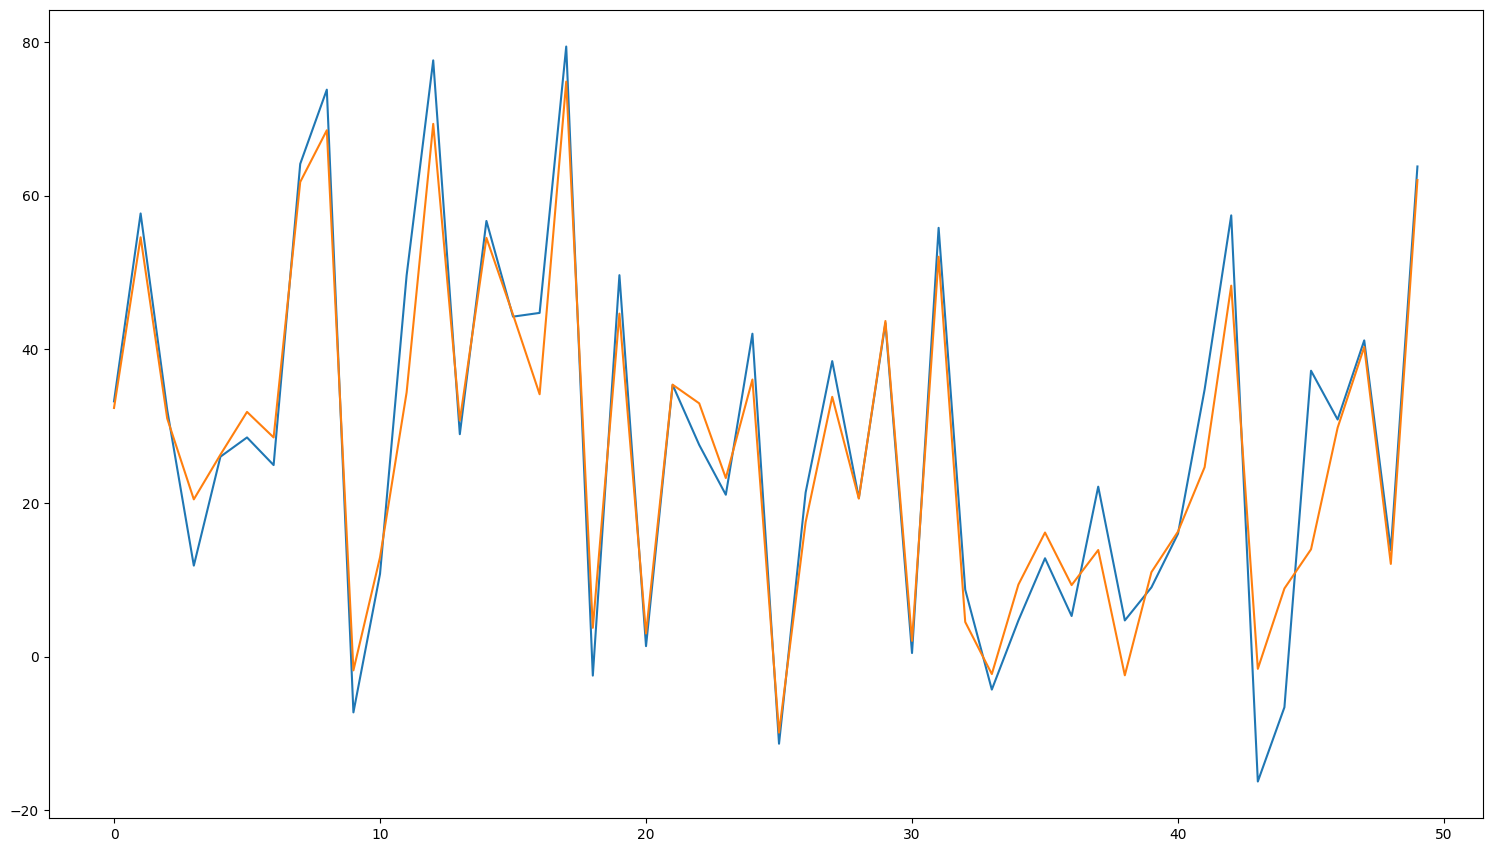

In [14]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Load and evaluate the model

In [15]:
from utils import get_data_pred

model.load_state_dict(torch.load("lstm-adjusted-500"))
out = get_data_pred('ACAvNTuEuFWcmwms', model, adjust=True, crop='corn')
out

tensor([[ 75.3805],
        [ 75.4429],
        [129.0984],
        [139.2952],
        [128.8876],
        [133.1449],
        [144.2295],
        [164.3298],
        [129.8442],
        [151.6084],
        [140.4799],
        [149.0764],
        [149.4333],
        [154.5029],
        [150.9960],
        [107.0173],
        [137.2893]])

In [222]:
# outputs # of the model we trained without the adjustments

tensor([[100.2934],
        [ 96.1967],
        [ 95.1817],
        [112.0884],
        [ 98.1280],
        [ 88.9596],
        [156.1279],
        [137.4307],
        [ 74.4149],
        [108.9806],
        [119.3128],
        [126.0991],
        [127.9114],
        [104.2989],
        [106.2627],
        [154.4127],
        [ 77.3407]], grad_fn=<AddmmBackward0>)

In [16]:
out # oof the model we trained with the adjustments

tensor([[114.4748],
        [ 63.8450],
        [124.6391],
        [138.7735],
        [141.8226],
        [141.1663],
        [148.0757],
        [131.5047],
        [132.3883],
        [155.8086],
        [149.0855],
        [144.8992],
        [136.4871],
        [154.3260],
        [161.6747],
        [110.9454],
        [144.0197]])

### Plot the loss

In [16]:
res = pd.DataFrame(data=np.asarray([train_losses, test_losses])).transpose()
res.columns = ['Train loss','Test loss']

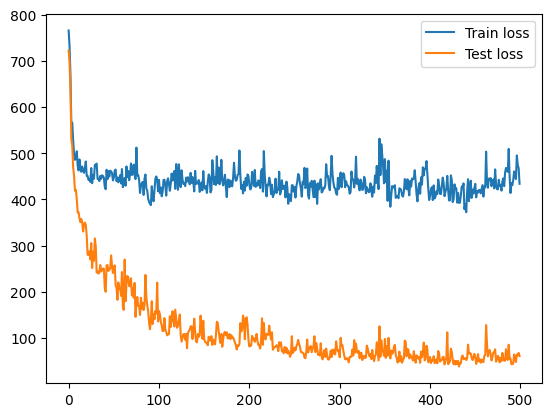

In [17]:
import matplotlib.pyplot as plt
res.plot()
plt.savefig('lstm-adjusted-500-losses.png')

<Axes: >

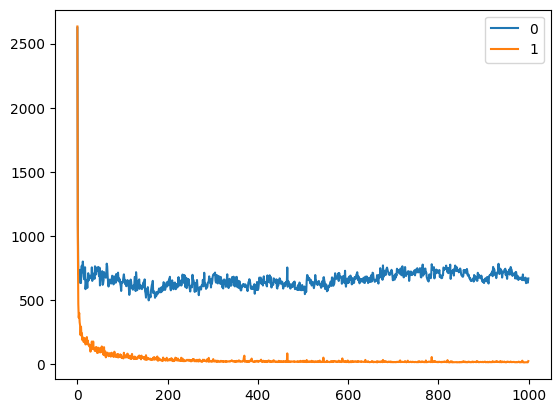

In [72]:
# res.plot() # training without adjustments 